# FenGen个性化联邦学习例子

In [1]:
%load_ext autoreload
%autoreload 2

## 在secretflow环境创造3个实体[Alice，Bob，Charlie]，其中 Alice, Bob和Charlie 是三个PYU，Alice和Bob角色是client，Charlie角色是server。

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], address='local')
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

/home/yang/anaconda3/envs/mysf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-23 10:03:08,660	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


The version of SecretFlow: 1.9.0.dev20240726


/home/yang/anaconda3/envs/mysf/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-10-23 10:03:11,837	INFO worker.py:1724 -- Started a local Ray instance.


In [3]:
spu = sf.SPU(sf.utils.testing.cluster_def(['alice', 'bob']))

## 导入相关依赖

In [4]:
from secretflow.ml.nn.core.torch import (
    metric_wrapper,
    optim_wrapper,
    BaseModule,
    TorchModel,
)
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from secretflow.utils.simulation.datasets import load_mnist
from torch import nn, optim
from torch.nn import functional as F
import torch

2024-10-23 10:03:16.561553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 数据划分，这里模拟数据不平衡2:8分

In [5]:
(train_data, train_label), (test_data, test_label) = load_mnist(
    parts={alice: 0.2, bob: 0.8},
    normalized_x=True,
    categorical_y=True,
    is_torch=True,
)

## 定义一个神经网络模型，输出是logit

In [6]:
class ConvNet(BaseModule):
    """Small ConvNet for MNIST."""

    def __init__(self, kl_div_loss, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc_in_dim = 192
        self.fc = nn.Linear(self.fc_in_dim, 10)
        self.kl_div_loss = kl_div_loss
        self.num_classes = num_classes

    def forward(self, x, start_layer_idx=0):
        if start_layer_idx == -1:
            x = self.fc(x)
            return x
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.fc_in_dim)
        x = self.fc(x)
        return x

定义神经网络模型的损失函数和优化器

In [7]:
loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.Adam, lr=1e-2)

## 准备FedGen相关工作，生成器模型等

DiversityLoss是一个自定义的损失函数类

In [8]:
class DiversityLoss(nn.Module):
    """
    Diversity loss for improving the performance.
    """

    def __init__(self, metric):
        """
        Class initializer.
        """
        super().__init__()
        self.metric = metric
        self.cosine = nn.CosineSimilarity(dim=2)

    def compute_distance(self, tensor1, tensor2, metric):
        """
        Compute the distance between two tensors.
        """
        if metric == 'l1':
            return torch.abs(tensor1 - tensor2).mean(dim=(2,))
        elif metric == 'l2':
            return torch.pow(tensor1 - tensor2, 2).mean(dim=(2,))
        elif metric == 'cosine':
            return 1 - self.cosine(tensor1, tensor2)
        else:
            raise ValueError(metric)

    def pairwise_distance(self, tensor, how):
        """
        Compute the pairwise distances between a Tensor's rows.
        """
        n_data = tensor.size(0)
        tensor1 = tensor.expand((n_data, n_data, tensor.size(1)))
        tensor2 = tensor.unsqueeze(dim=1)
        return self.compute_distance(tensor1, tensor2, how)

    def forward(self, noises, layer):
        """
        Forward propagation.
        """
        if len(layer.shape) > 2:
            layer = layer.view((layer.size(0), -1))
        layer_dist = self.pairwise_distance(layer, how=self.metric)
        noise_dist = self.pairwise_distance(noises, how='l2')
        return torch.exp(torch.mean(-noise_dist * layer_dist))

FedGen需要有generator模型,并一些训练参数相关设置，优化器等

In [9]:
from secretflow.ml.nn.fl.backend.torch.strategy.fed_gen import (
    FedGenGeneratorModel,
    FedGenActor,
)

kl_div_loss = nn.KLDivLoss(reduction="batchmean")
diversity_loss = DiversityLoss(metric='l1')
cross_entropy_loss = nn.CrossEntropyLoss()
num_classes = 10
generator = FedGenGeneratorModel(
    hidden_dimension=256,
    latent_dimension=192,
    noise_dim=64,
    num_classes=num_classes,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    diversity_loss=diversity_loss,
)

## 进行联邦学习

In [10]:
from secretflow.security.aggregation.stateful_fedgen_aggregator import (
    StatefulFedGenAggregator,
)

net = ConvNet(diversity_loss, 20)

model_def = TorchModel(
    model_fn=ConvNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
    ],
    kl_div_loss=kl_div_loss,
    num_classes=num_classes,
)

server_actor = FedGenActor(device=charlie, generator=generator)
device_list = [alice, bob]
aggregator = StatefulFedGenAggregator(charlie, [alice, bob], server_actor)
# spcify params
fl_model = FLModel(
    server=charlie,
    device_list=device_list,
    model=model_def,
    strategy="fed_gen",  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
    aggregator=aggregator,
    generator=generator,
)
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=32,
    aggregate_freq=1,
)

INFO:root:Create proxy actor <class 'secretflow.device.proxy.ActorFedGenActor'> with party charlie.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party bob.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedGen'> with party alice.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedGen'> with party bob.
INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fba63bc4130>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fba63bc4b50>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fba63bc54b0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fba63bc4070>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 32, 'batch_s

Epoch 1/20


(ActorFedGenActor pid=596183) /home/yang/anaconda3/envs/mysf/lib/python3.10/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
(ActorFedGenActor pid=596183)   warnings.warn(
(pid=596362) 2024-10-23 10:03:34.443714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
Train Processing: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 374/375 [01:13<00:00,  4.48it/s]/home/yang/PycharmProjec

Epoch 2/20
(ActorPYUFedGen pid=596361) {'train-loss': 7.240610122680664, 'train_multiclassaccuracy': tensor(0.7905), 'train_multiclassprecision': tensor(0.7905), 'val_eval_multiclassaccuracy': tensor(0.8730), 'val_eval_multiclassprecision': tensor(0.8730)}


Train Processing: : 100%|▉| 374/375 [00:38<00:00,  9.78it/s, {'multiclassaccuracy': 0.91835415, 'multiclassprecision': 0.91835415, 'val_multiclassaccuracy': 0.9181875, 'val_multicl
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:56,  6.63it/s]

Epoch 3/20
(ActorPYUFedGen pid=596361) {'train-loss': 3.871393918991089, 'train_multiclassaccuracy': tensor(0.9191), 'train_multiclassprecision': tensor(0.9191), 'val_eval_multiclassaccuracy': tensor(0.9020), 'val_eval_multiclassprecision': tensor(0.9020)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:37<00:00,  9.90it/s, {'multiclassaccuracy': 0.93016666, 'multiclassprecision': 0.93016666, 'val_multiclassaccuracy': 0.9263125, 'val_multicl
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:58,  6.39it/s]

Epoch 4/20
(ActorPYUFedGen pid=596361) {'train-loss': 3.469554901123047, 'train_multiclassaccuracy': tensor(0.9317), 'train_multiclassprecision': tensor(0.9317), 'val_eval_multiclassaccuracy': tensor(0.9125), 'val_eval_multiclassprecision': tensor(0.9125)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:34<00:00, 10.73it/s, {'multiclassaccuracy': 0.93403125, 'multiclassprecision': 0.93403125, 'val_multiclassaccuracy': 0.928125, 'val_multicla
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<01:00,  6.14it/s]

Epoch 5/20
(ActorPYUFedGen pid=596361) {'train-loss': 3.194899559020996, 'train_multiclassaccuracy': tensor(0.9355), 'train_multiclassprecision': tensor(0.9355), 'val_eval_multiclassaccuracy': tensor(0.9140), 'val_eval_multiclassprecision': tensor(0.9140)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:34<00:00, 11.00it/s, {'multiclassaccuracy': 0.9375833, 'multiclassprecision': 0.9375833, 'val_multiclassaccuracy': 0.9320625, 'val_multiclas
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:59,  6.29it/s]

Epoch 6/20
(ActorPYUFedGen pid=596361) {'train-loss': 3.116774559020996, 'train_multiclassaccuracy': tensor(0.9392), 'train_multiclassprecision': tensor(0.9392), 'val_eval_multiclassaccuracy': tensor(0.9205), 'val_eval_multiclassprecision': tensor(0.9205)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:32<00:00, 11.39it/s, {'multiclassaccuracy': 0.93965626, 'multiclassprecision': 0.93965626, 'val_multiclassaccuracy': 0.9373125, 'val_multicl
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:58,  6.41it/s]

Epoch 7/20
(ActorPYUFedGen pid=596361) {'train-loss': 2.8242197036743164, 'train_multiclassaccuracy': tensor(0.9411), 'train_multiclassprecision': tensor(0.9411), 'val_eval_multiclassaccuracy': tensor(0.9265), 'val_eval_multiclassprecision': tensor(0.9265)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:33<00:00, 11.06it/s, {'multiclassaccuracy': 0.9405625, 'multiclassprecision': 0.9405625, 'val_multiclassaccuracy': 0.938625, 'val_multiclass
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<01:12,  5.17it/s]

Epoch 8/20
(ActorPYUFedGen pid=596361) {'train-loss': 2.6636083126068115, 'train_multiclassaccuracy': tensor(0.9416), 'train_multiclassprecision': tensor(0.9416), 'val_eval_multiclassaccuracy': tensor(0.9280), 'val_eval_multiclassprecision': tensor(0.9280)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:34<00:00, 10.95it/s, {'multiclassaccuracy': 0.9417083, 'multiclassprecision': 0.9417083, 'val_multiclassaccuracy': 0.9391875, 'val_multiclas
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 9/20
(ActorPYUFedGen pid=596361) {'train-loss': 2.566133499145508, 'train_multiclassaccuracy': tensor(0.9428), 'train_multiclassprecision': tensor(0.9428), 'val_eval_multiclassaccuracy': tensor(0.9280), 'val_eval_multiclassprecision': tensor(0.9280)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:34<00:00, 10.75it/s, {'multiclassaccuracy': 0.9431771, 'multiclassprecision': 0.9431771, 'val_multiclassaccuracy': 0.9399375, 'val_multiclas
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<01:04,  5.82it/s]

Epoch 10/20
(ActorPYUFedGen pid=596361) {'train-loss': 2.377262592315674, 'train_multiclassaccuracy': tensor(0.9445), 'train_multiclassprecision': tensor(0.9445), 'val_eval_multiclassaccuracy': tensor(0.9290), 'val_eval_multiclassprecision': tensor(0.9290)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:37<00:00,  9.99it/s, {'multiclassaccuracy': 0.9437916, 'multiclassprecision': 0.9437916, 'val_multiclassaccuracy': 0.940125, 'val_multiclass
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<01:00,  6.17it/s]

Epoch 11/20
(ActorPYUFedGen pid=596361) {'train-loss': 2.2059271335601807, 'train_multiclassaccuracy': tensor(0.9450), 'train_multiclassprecision': tensor(0.9450), 'val_eval_multiclassaccuracy': tensor(0.9280), 'val_eval_multiclassprecision': tensor(0.9280)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:35<00:00, 10.61it/s, {'multiclassaccuracy': 0.94498956, 'multiclassprecision': 0.94498956, 'val_multiclassaccuracy': 0.94025, 'val_multiclas
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<01:04,  5.84it/s]

Epoch 12/20
(ActorPYUFedGen pid=596361) {'train-loss': 2.115673065185547, 'train_multiclassaccuracy': tensor(0.9463), 'train_multiclassprecision': tensor(0.9463), 'val_eval_multiclassaccuracy': tensor(0.9280), 'val_eval_multiclassprecision': tensor(0.9280)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:34<00:00, 10.94it/s, {'multiclassaccuracy': 0.9458333, 'multiclassprecision': 0.9458333, 'val_multiclassaccuracy': 0.9413125, 'val_multiclas
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:58,  6.36it/s]

Epoch 13/20
(ActorPYUFedGen pid=596361) {'train-loss': 1.943589448928833, 'train_multiclassaccuracy': tensor(0.9469), 'train_multiclassprecision': tensor(0.9469), 'val_eval_multiclassaccuracy': tensor(0.9300), 'val_eval_multiclassprecision': tensor(0.9300)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:35<00:00, 10.45it/s, {'multiclassaccuracy': 0.9465208, 'multiclassprecision': 0.9465208, 'val_multiclassaccuracy': 0.94306254, 'val_multicla
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<01:04,  5.84it/s]

Epoch 14/20
(ActorPYUFedGen pid=596361) {'train-loss': 2.120236396789551, 'train_multiclassaccuracy': tensor(0.9481), 'train_multiclassprecision': tensor(0.9481), 'val_eval_multiclassaccuracy': tensor(0.9330), 'val_eval_multiclassprecision': tensor(0.9330)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:33<00:00, 11.03it/s, {'multiclassaccuracy': 0.9479271, 'multiclassprecision': 0.9479271, 'val_multiclassaccuracy': 0.9443125, 'val_multiclas
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:57,  6.49it/s]

Epoch 15/20
(ActorPYUFedGen pid=596361) {'train-loss': 1.9986705780029297, 'train_multiclassaccuracy': tensor(0.9499), 'train_multiclassprecision': tensor(0.9499), 'val_eval_multiclassaccuracy': tensor(0.9340), 'val_eval_multiclassprecision': tensor(0.9340)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:32<00:00, 11.39it/s, {'multiclassaccuracy': 0.94815624, 'multiclassprecision': 0.94815624, 'val_multiclassaccuracy': 0.94449997, 'val_multic
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<01:00,  6.19it/s]

Epoch 16/20
(ActorPYUFedGen pid=596361) {'train-loss': 1.9143987894058228, 'train_multiclassaccuracy': tensor(0.9501), 'train_multiclassprecision': tensor(0.9501), 'val_eval_multiclassaccuracy': tensor(0.9335), 'val_eval_multiclassprecision': tensor(0.9335)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:33<00:00, 11.31it/s, {'multiclassaccuracy': 0.94853127, 'multiclassprecision': 0.94853127, 'val_multiclassaccuracy': 0.945125, 'val_multicla
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:56,  6.59it/s]

Epoch 17/20
(ActorPYUFedGen pid=596361) {'train-loss': 1.7454423904418945, 'train_multiclassaccuracy': tensor(0.9503), 'train_multiclassprecision': tensor(0.9503), 'val_eval_multiclassaccuracy': tensor(0.9340), 'val_eval_multiclassprecision': tensor(0.9340)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:32<00:00, 11.34it/s, {'multiclassaccuracy': 0.94883335, 'multiclassprecision': 0.94883335, 'val_multiclassaccuracy': 0.94568753, 'val_multic
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:59,  6.32it/s]

Epoch 18/20
(ActorPYUFedGen pid=596361) {'train-loss': 1.7196615934371948, 'train_multiclassaccuracy': tensor(0.9505), 'train_multiclassprecision': tensor(0.9505), 'val_eval_multiclassaccuracy': tensor(0.9350), 'val_eval_multiclassprecision': tensor(0.9350)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:33<00:00, 11.32it/s, {'multiclassaccuracy': 0.94934374, 'multiclassprecision': 0.94934374, 'val_multiclassaccuracy': 0.94568753, 'val_multic
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:58,  6.35it/s]

Epoch 19/20
(ActorPYUFedGen pid=596361) {'train-loss': 1.5121980905532837, 'train_multiclassaccuracy': tensor(0.9510), 'train_multiclassprecision': tensor(0.9510), 'val_eval_multiclassaccuracy': tensor(0.9340), 'val_eval_multiclassprecision': tensor(0.9340)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:33<00:00, 11.19it/s, {'multiclassaccuracy': 0.94985414, 'multiclassprecision': 0.94985414, 'val_multiclassaccuracy': 0.9450625, 'val_multicl


(ActorPYUFedGen pid=596361) {'train-loss': 1.4355396032333374, 'train_multiclassaccuracy': tensor(0.9516), 'train_multiclassprecision': tensor(0.9516), 'val_eval_multiclassaccuracy': tensor(0.9330), 'val_eval_multiclassprecision': tensor(0.9330)} [repeated 2x across cluster]


Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:58,  6.34it/s]

Epoch 20/20


Train Processing: : 100%|▉| 374/375 [00:34<00:00, 10.99it/s, {'multiclassaccuracy': 0.94983333, 'multiclassprecision': 0.94983333, 'val_multiclassaccuracy': 0.9460625, 'val_multicl


## 绘制结果

(ActorPYUFedGen pid=596361) {'train-loss': 1.4233253002166748, 'train_multiclassaccuracy': tensor(0.9514), 'train_multiclassprecision': tensor(0.9514), 'val_eval_multiclassaccuracy': tensor(0.9340), 'val_eval_multiclassprecision': tensor(0.9340)}


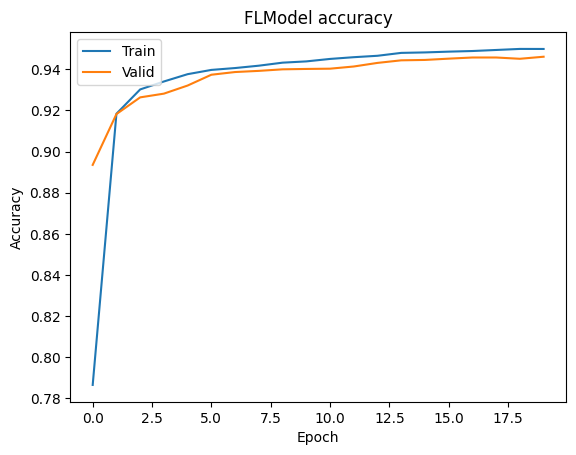

In [11]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]['multiclassaccuracy'])
plt.plot(history["global_history"]['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()